In [1]:
# conda env create --name ubs_dlcv python==3.12

In [2]:
# Install or upgrade the ultralytics package from PyPI
# !pip install ultralytics #https://docs.ultralytics.com/quickstart/
# !pip install numpy # not working in conda env
# !conda install numpy -y
# %pip install pylabel
# %pip install ultralytics

In [2]:
from ultralytics import YOLO
import numpy as np
# import pylabel
import random
import os
import json
import shutil
from pylabel import importer, exporter, visualize
import glob


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.4.0 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/Users/rabinatwayana/miniforge3/envs/ubs_dlcv/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/Users/rabinatwayana/miniforge3/envs/ubs_dlcv/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/Users/rabinatwayana/miniforge3/envs/ubs_dlcv/lib/python3.12/site-packages/ipykernel/kernelapp

## convert annotations from the COCO format to YOLO 

In [4]:
convert_to_yolo = False
if convert_to_yolo:
    dataset_root = "dataset/SARscope"
    output_root = "dataset/yolo"

    if os.path.exists(output_root):
        shutil.rmtree(output_root)
        print(f"Deleted existing folder: {output_root}")
        
    splits = ["train", "valid", "test"]

    images_root = os.path.join(output_root, "images")
    labels_root = os.path.join(output_root, "labels")

    for split in splits:
        os.makedirs(os.path.join(images_root,split), exist_ok=True)
        os.makedirs(os.path.join(labels_root, split), exist_ok=True)

        print(f"Processing split: {split}")
        json_file = os.path.join(dataset_root, split, "_annotations.coco.json")
        images_dir = os.path.join(dataset_root, split)

        # Import dataset JSON
        dataset = importer.ImportCoco(
            path=json_file,
            path_to_images=images_dir
        )

        # Export YOLO labels and copy images
        # temp_out = os.path.join(output_root, split)
        labels_out = os.path.join(labels_root, split)

        dataset.export.ExportToYoloV5(labels_out)
        
        # for fname in os.listdir(temp_out):
        #     shutil.move(os.path.join(temp_out, fname),
        #                 os.path.join(labels_root, split, fname))
            
        for img_path in glob.glob(os.path.join(images_dir, "*.jpg")):
            fname = os.path.basename(img_path)  # get filename only
            shutil.copy(img_path, os.path.join(images_root, split, fname))

        # Remove the temporary folder
        # shutil.rmtree(temp_out)

    # Create dataset.yaml
    with open(os.path.join(dataset_root, "train", "_annotations.coco.json")) as f:
        data = json.load(f)

    categories = data["categories"]
    names_dict = {i: c["name"] for i, c in enumerate(categories)}

    yaml_text = [
        f"path: {output_root}",
        "train: images/train",
        "val: images/valid",
        "test: images/test",
        "names:"
    ]
    for idx, nm in names_dict.items():
        yaml_text.append(f"  {idx}: {nm}")

    with open(os.path.join(output_root, "dataset.yaml"), "w") as f:
        f.write("\n".join(yaml_text))


In [5]:
import os
import cv2
import matplotlib.pyplot as plt

def show_yolo_image(image_path, label_path):
    """ 
    image_path: path to .jpg image
    label_path: path to corresponding .txt label
    """
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w, _ = img.shape

    # Read YOLO annotations
    # if os.path.exists(label_path):
    with open(label_path) as f:
        for line in f.readlines():
            parts = line.strip().split()
            class_id, x_center, y_center, bw, bh = map(float, parts)

            # Convert from normalized to pixel coordinates
            x_center *= w  # pixel x-coordinate of box center
            y_center *= h  # pixel y-coordinate of box center
            bw *= w        # box width in pixels
            bh *= h        # box height in pixels


            x1 = int(x_center - bw/2) #left
            y1 = int(y_center - bh/2) #top
            x2 = int(x_center + bw/2) #right
            y2 = int(y_center + bh/2) #bottom

            # Draw rectangle
            color = (255, 0, 0)
            cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)

    return img

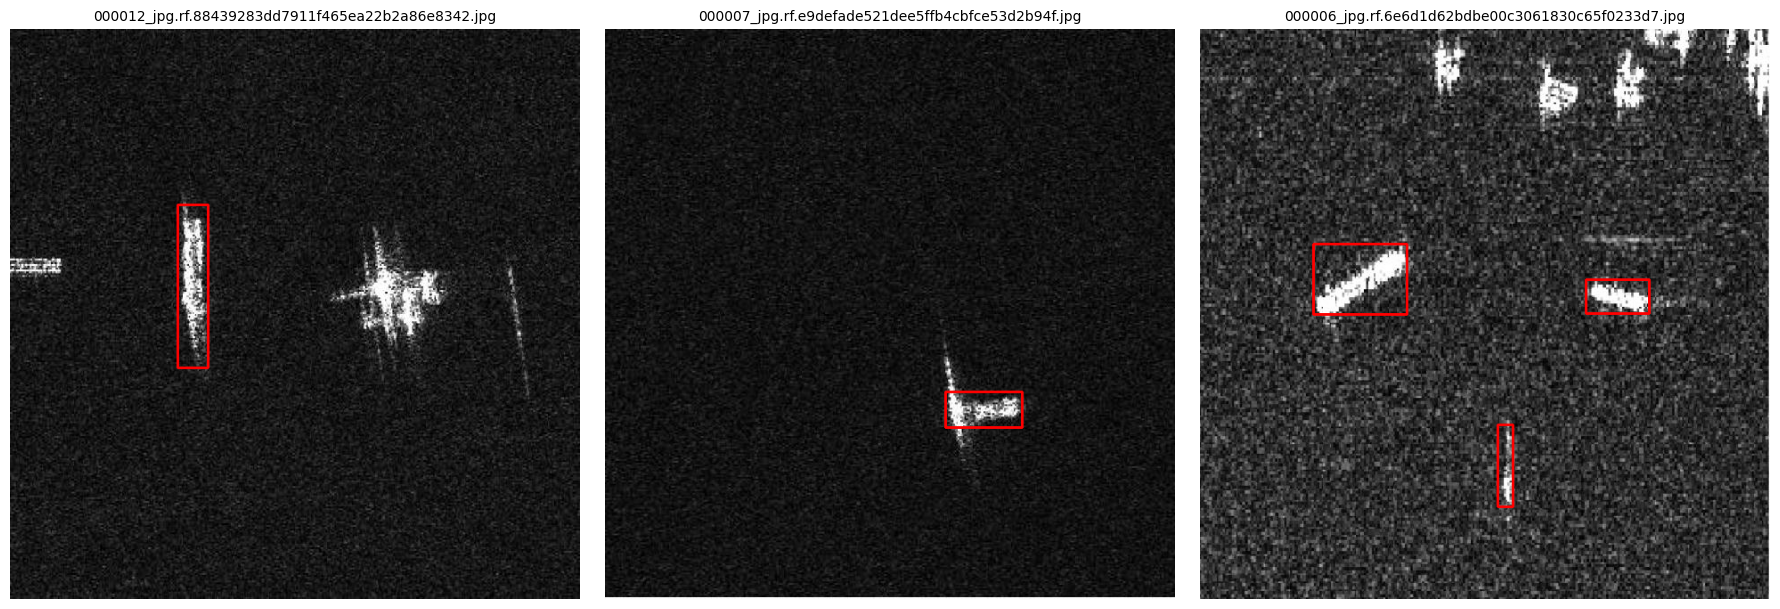

In [8]:

train_img_dir = "dataset/yolo/images/train"
train_lbl_dir = "dataset/yolo/labels/train"
no_of_images=6
sample_images = random.sample(os.listdir(train_img_dir), no_of_images)

# Plot them in the same row
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for ax, img_file in zip(axes, sample_images):
    image_path = os.path.join(train_img_dir, img_file)
    label_file = img_file.replace(".jpg", ".txt")
    label_path = os.path.join(train_lbl_dir, label_file)
    
    img = show_yolo_image(image_path, label_path)
    ax.imshow(img)
    ax.axis("off")
    ax.set_title(img_file, fontsize=10)

plt.tight_layout()
plt.show()



In [5]:
# Load a COCO-pretrained YOLOv8n model
model = YOLO("yolov8m.pt")
# Display model information (optional)
model.info()


YOLOv8m summary: 169 layers, 25,902,640 parameters, 0 gradients, 79.3 GFLOPs


(169, 25902640, 0, 79.3204224)

In [ ]:
# Train the model on the COCO8 example dataset for 100 epochs
results = model.train(data="dataset/yolo/dataset.yaml", epochs=2, imgsz=640, device="mps")

# Run inference with the YOLOv8n model on the 'bus.jpg' image
# results = model("path/to/bus.jpg")

Ultralytics 8.3.252 🚀 Python-3.12.12 torch-2.2.2 MPS (Apple M3)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=dataset/yolo/dataset.yaml, degrees=0.0, deterministic=True, device=mps, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=2, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train8, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=True, p